In [51]:
import os 
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, f_regression, SelectFromModel, mutual_info_regression
from scipy.stats import f_oneway
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
os.chdir('..')

In [3]:
df = pd.read_csv('ENG_DATA/CLEANED/12-8_Cleaned_df.csv', index_col = [0])

In [4]:
#fix a bug 
for l in ['charter', 'private', 'public', 'gsRating', 'enrollment']: 
    df[l].fillna(df[l].mean(), inplace=True)

In [5]:
x = df.drop(columns = ['sale_price', 'orig_list_price', 'city'])
y = df.sale_price
x_num = x.select_dtypes(include = 'number')
x_cat = x.select_dtypes(exclude = 'number')

In [68]:
keep_columns = list(df.columns)[:list(df.columns).index('charter')]

In [71]:
df_no_school_or_crime = df[keep_columns]

In [74]:
df_no_school_or_crime.drop(columns='orig_list_price', inplace=True)

In [13]:
# Choose Number of Features to select - 77 total features, 64 numerical features, 13 categorical features
len(list(x_num.columns))
len(list(x_cat.columns))
# Select 50% of features 
num_num_features = int(0.5*len(list(x_num.columns)))
num_cat_features = int(0.5*len(list(x_cat.columns)))

In [62]:
# Label encode categories
le=LabelEncoder()

# create a dataframe to store label encoded values
x_cat_le = x_cat.copy()

for i in x_cat.columns:
    le.fit(x_cat[i])
    x_cat_le[i] = le.transform(x_cat[i]).copy()

In [6]:
len(df.loc[df['charter'].isnull(), ['neighborhood', 'charter']]['neighborhood'].unique())

0

In [7]:
x_num[['charter', 'private', 'public', 'gsRating', 'enrollment',]].isnull().sum()

charter       0
private       0
public        0
gsRating      0
enrollment    0
dtype: int64

In [21]:
reg = mutual_info_regression(x_num, df["sale_price"])

In [37]:
cols = [idx for idx, val in enumerate(reg) if val > 0.05]
x_num_select = x_num[x_num.columns[cols]]
num_mi_df = pd.DataFrame(reg, index = x_num.columns, columns = ['mutual_information'])

Text(0.5, 1, 'Top 10 Continuous Features - Mutual Information Regression')

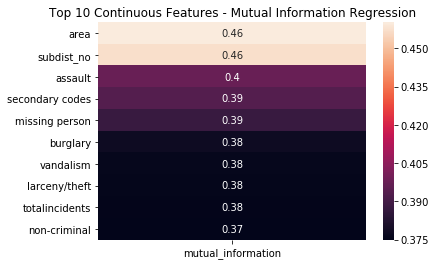

In [69]:
num_top10_features = num_mi_df.sort_values(by = 'mutual_information', ascending=False).head(10)
sns.heatmap(data = num_top10_features, annot=True )
plt.title('Top 10 Continuous Features - Mutual Information Regression')

In [64]:
reg_cat = mutual_info_regression(x_cat_le, df["sale_price"], discrete_features = True, n_neighbors=5, copy=True)

In [71]:
cols_cat = [idx for idx, val in enumerate(reg_cat) if val > 0.15]
x_cat_select = x_cat[x_cat.columns[cols_cat]]
cat_mi_df = pd.DataFrame(reg_cat, index = x_cat.columns, columns = ['mutual_information'])

Text(0.5, 1, 'Top 10 Categorical Features - Mutual Information Regression')

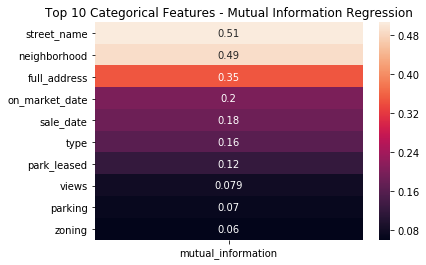

In [72]:
cat_top10_features = cat_mi_df.sort_values(by = 'mutual_information', ascending=False).head(10)
sns.heatmap(data = cat_top10_features, annot=True )
plt.title('Top 10 Categorical Features - Mutual Information Regression')

In [42]:
def categorical_filter(df__, low_exclusive = 2, high_inclusive = 15):
    """function returns features (col_names) that have unique values
    less than or equal to n_categories
    
    """ 
    list_of_features = []
    for i in df__.columns:
        if low_exclusive == high_inclusive:
            if df__[i].nunique() <= low_exclusive :
                list_of_features.append(i)
        else:
            if df__[i].nunique() <= high_inclusive and df__[i].nunique() > low_exclusive :
                list_of_features.append(i)
    return list_of_features

In [49]:
categorical_filter(x_cat, 2, 40)

['zoning', 'drive_side', 'park_leased', 'shopping', 'transportation']

In [16]:
x_cat.drop(columns = ['full_address', 'on_market_date', 'sale_date'], inplace=True)

/Users/37138/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [40]:
def numerical_encoding(dataset, nominal_columns='all'):
    if nominal_columns is None:
        return dataset
    elif nominal_columns == 'all':
        nominal_columns = dataset.columns
    converted_dataset = pd.DataFrame()
    binary_columns_dict = dict()
    for col in dataset.columns:
        if col not in nominal_columns:
            converted_dataset.loc[:,col] = dataset[col]
        else:
            unique_values = pd.unique(dataset[col])
            if len(unique_values) == 1 and not drop_single_label:
                print("col")
                converted_dataset.loc[:,col] = 0
            elif len(unique_values) == 2:
                converted_dataset.loc[:,col], binary_columns_dict[col] = pd.factorize(dataset[col])
            elif ',' in ' '.join(unique_values):
                print(col)
                dummies = dataset[col].str.get_dummies(sep=',')
                converted_dataset = pd.concat([converted_dataset,dummies],axis=1)
            else:
                dummies = pd.get_dummies(dataset[col],prefix=col)
                converted_dataset = pd.concat([converted_dataset,dummies],axis=1)
    return converted_dataset

In [41]:
x_cat_dummies = numerical_encoding(x_cat)

drive_side
parking
shopping
transportation
type
views


In [46]:
len(list(x_cat_dummies.columns))

2153

In [43]:
df_out_1hot_encoded = df.select_dtypes(include = 'number').join(x_cat_dummies)

## Prepare for Export

In [78]:
df_out = x_num_select.copy()
df_out = df_out.join(x_cat_select)
df_out = df_out.join(y)

In [80]:
train, test = train_test_split(df_out, test_size = 0.2)

In [81]:
train.to_csv('ENG_DATA/SELECTED/12-8_train.csv')
test.to_csv('ENG_DATA/SELECTED/12-8_test.csv')

In [61]:
def export_train_test(df_, name_):
    train, test = train_test_split(df_, test_size = 0.2)
    month_day = datetime.now().strftime('%m-%d')
    train.to_csv('ENG_DATA/SELECTED/{}_{}_train.csv'.format(month_day, name_))
    test.to_csv('ENG_DATA/SELECTED/{}_{}_test.csv'.format(month_day, name_))

In [63]:
export_train_test(df_out_1hot_encoded, "1he")

In [64]:
export_train_test(df, "all")

In [75]:
export_train_test(df_no_school_or_crime, "hedon")